# Underwater Image Enhancement with Deconvolution

## Introduction

This notebook explores underwater image enhancement using deconvolution techniques. Underwater images often suffer from issues like poor visibility, color distortion, and low contrast due to light absorption and scattering in water. Deconvolution offers a method to restore and enhance these images by reversing the effects of blur and distortion.

Below, we import the necessary libraries.

In [1]:
# imports
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from utils.image_loader import LazyImageLoader

## Utility Functions

In this section, we will cover the utility functions used throughout the notebook.

### Custom Dataset Wrapper: `LazyImageLoaderDataset`

This class serves as a custom dataset wrapper, making it easy to integrate the LazyImageLoader with PyTorch's DataLoader. It enables efficient data loading for training by handling tasks such as image pairing and optional transformations.

In [2]:
# Class that wraps the LazyImageLoader so it can be used as a Torch Dataloader
class LazyImageLoaderDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            root (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.loader = LazyImageLoader(root)
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of image pairs.
        """
        return len(self.loader)
    
    def __getitem__(self, i):
        """
        Retrieves the pair of images at the specified index and applies transformation (if any).
        
        Args:
            i (int): Index of the image pair.
        
        Returns:
            tuple: A tuple of transformed images (low-quality, high-quality).
        """
        imgA, imgB = self.loader[i]
        
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB

### Functions to Save and Load Model Checkpoints

In this section, we define two functions for saving and loading model and optimizer states, which help manage training progress.

- `save_checkpoint()` saves the model and optimizer's state to a specified file. It creates a checkpoint directory (if it doesn't exist) and stores the model and optimizer state dictionaries. This allows you to save your progress and resume training later.

- `load_checkpoint()` loads a saved checkpoint from a file and restores the model and optimizer states. This function is useful when you want to continue training or evaluate the model from a previously saved state.

In [3]:
# Functions to save and load model/optimizer
def save_checkpoint(model, optimizer, filename="checkpoint.pth", save_dir="checkpoints"):
    """
    Saves the model and optimizer state_dicts to a specified directory.
    
    Args:
        model (nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer to save.
        filename (str, optional): The name of the checkpoint file. Default is "checkpoint.pth".
        save_dir (str, optional): Directory where the checkpoint will be saved. Default is "checkpoints".
    """
    os.makedirs(save_dir, exist_ok=True)
    
    checkpoint_path = os.path.join(save_dir, filename)
    
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """
    Loads a saved checkpoint from the specified file.
    
    Args:
    - model: The model whose state dictionary (weights and biases) will be restored.
    - optimizer: The optimizer whose state dictionary (e.g., momentum, learning rate) will be restored.
    - filename: The file path of the checkpoint (default is "checkpoint.pth").
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Checkpoint loaded from {filename}")

### Function to Initialize Weights

The `initialize_weights()` function is used to initialize the weights and biases of the model using specific strategies tailored for different types of layers.

In [4]:
# Function to initialize weights
def initialize_weights(model):
    """
    Initializes the weights and biases of the model using specific strategies for different layers.
    
    Args:
    - model (torch.nn.Module): The model whose weights will be initialized.
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, mean=1.0, std=0.02)
            nn.init.constant_(m.bias, 0)

### Function to Visualize Samples

The `visualize_samples()` function displays a set of three images: the low-quality input image, the high-quality target image, and the generated output image.

This function provides a side-by-side comparison of the input, target, and generated images, helping to visually assess the model's performance.


In [5]:
# Visualizes samples provided in parameters
def visualize_samples(low_quality, high_quality, generated):
    """
    Visualizes a set of three images: low-quality input, high-quality target, and generated output.
    
    Args:
    - low_quality (torch.Tensor): Low-quality input image (expected to be normalized in the range [-1, 1]).
    - high_quality (torch.Tensor): High-quality target image (expected to be normalized in the range [-1, 1]).
    - generated (torch.Tensor): Generated image (expected to be normalized in the range [-1, 1]).
    """
    def denormalize(img):
        img = img * 0.5 + 0.5  # Convert range [-1, 1] back to [0, 1]
        img = img.permute(1, 2, 0).cpu().numpy()
        return img

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(denormalize(low_quality))
    axes[0].set_title("Low-Quality Input")
    axes[1].imshow(denormalize(high_quality))
    axes[1].set_title("High-Quality Target")
    axes[2].imshow(denormalize(generated))
    axes[2].set_title("Generated Output")
    plt.show()

### Function to Get Learning Rate Scheduler

The `get_scheduler()` function creates a learning rate scheduler that reduces the learning rate by a factor of gamma every step_size epochs.

This helps adjust the learning rate dynamically during training to improve convergence and avoid overshooting the optimal solution. 

The function returns a StepLR scheduler that can be used to adjust the learning rate during training.

In [6]:
def get_scheduler(optimizer, step_size=10, gamma=0.5):
    """
    Creates a learning rate scheduler that decays the learning rate by a factor of 'gamma' every 'step_size' steps.
    
    Args:
        optimizer (torch.optim.Optimizer): The optimizer for which to adjust the learning rate.
        step_size (int, optional): Period (in epochs) after which the learning rate will be decayed. Default is 10.
        gamma (float, optional): Multiplicative factor for learning rate decay. Default is 0.5.
    
    Returns:
        torch.optim.lr_scheduler.StepLR: The learning rate scheduler.
    """
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    return scheduler

### Functions to Calculate Image Quality Metrics

The following functions are used to evaluate the quality of generated images by comparing them with ground truth images.

- PSNR (Peak Signal-to-Noise Ratio): The `calculate_psnr()` function computes the PSNR value between two images. PSNR is a common metric used to measure the quality of images by comparing the peak signal (the maximum pixel value) to the noise (the difference between the generated and target images). A higher PSNR value indicates better image quality.

- SSIM (Structural Similarity Index): The `calculate_ssim()` function computes the SSIM score between two images. SSIM evaluates the structural similarity between two images based on luminance, contrast, and structure. A value closer to 1 indicates better similarity.

Both functions are useful for assessing how closely the model's output matches the target ground truth, providing quantitative metrics for image quality.

In [7]:
def calculate_psnr(output, target, max_pixel_value=1.0):
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between the output and target images.

    Args:
        output (torch.Tensor): The generated image or model output.
        target (torch.Tensor): The ground truth or target image.
        max_pixel_value (float, optional): The maximum pixel value in the image (e.g., 1.0 for normalized images). Default is 1.0.

    Returns:
        float: The PSNR value in decibels (dB).
    """
    mse = torch.mean((output - target) ** 2)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

In [8]:
def calculate_ssim(image1, image2):
    """
    Compute the SSIM (Structural Similarity Index) between two images.

    Args:
        image1 (Tensor): The first image (predicted/restored).
        image2 (Tensor): The second image (ground truth).
    
    Returns:
        ssim_value (float): The SSIM score between the two images.
    """
    image1 = image1.cpu().numpy().transpose(1, 2, 0)
    image2 = image2.cpu().numpy().transpose(1, 2, 0)
    
    image1 = np.clip(image1 * 255, 0, 255).astype(np.uint8)
    image2 = np.clip(image2 * 255, 0, 255).astype(np.uint8)

    ssim_value, _ = ssim(image1, image2, full=True, multichannel=True)

    return ssim_value

### Function to Train the Model for One Epoch

The `train_one_epoch()` function performs the training of the model for a single epoch. It iterates over the provided dataloader that contains pairs of low-quality and high-quality images. 

This function is used to train the model in batches, and the progress is displayed using tqdm to show the loss in each iteration.


In [9]:
def train_one_epoch(dataloader, model, optimizer, criterion, device):
    """
    Trains the model for one epoch on the given dataloader.
    
    Args:
        dataloader (DataLoader): The DataLoader containing image pairs (low_quality, high_quality).
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer to update model weights.
        criterion (nn.Module): The loss function (e.g., MSELoss).
        device (torch.device): The device to perform computations on (e.g., 'cuda' or 'cpu').
    """
    model.train()
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        low_quality, high_quality = batch
        low_quality, high_quality = low_quality.to(device), high_quality.to(device)

        generated = model(low_quality)
        loss = criterion(generated, high_quality)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description("Training Epoch")
        loop.set_postfix(loss=loss.item())

## Deconvolution
In convolutional neural networks, convolution layers are used for feature extraction, where filters slide over the input image to create feature maps that capture important information like edges, textures, and patterns. These operations typically reduce the spatial resolution (height and width) of the input image, which is known as downsampling.

On the other hand, deconvolution (or transpose convolution) is the opposite operation of convolution. It is used to increase the spatial resolution of feature maps, essentially performing upsampling. The goal of deconvolution is to reverse the effects of downsampling by generating higher-resolution output from lower-resolution feature maps.

In [10]:
class DeconvolutionModel(nn.Module):
    """
    A neural network model that performs image restoration using convolutional layers for encoding
    (downsampling) and deconvolution (transpose convolution) layers for decoding (upsampling).
    
    The model consists of two main components:
    1. Encoder: Downsamples the input image using Conv2d layers with ReLU activations.
    2. Decoder: Upsamples the feature maps using ConvTranspose2d layers, with the final layer producing
       an output with 3 channels (RGB).
    
    The model is designed to map low-resolution images to high-resolution outputs.

    Methods:
        forward(x): Defines the forward pass, taking the input tensor 'x' and passing it through the encoder
                    and decoder to produce the output.
    """
    def __init__(self):
        """
        Initializes the DeconvolutionModel. Defines the encoder and decoder parts of the network.

        The encoder reduces the spatial dimensions of the input image, and the decoder restores
        the spatial dimensions back to the original image size.
        """
        super(DeconvolutionModel, self).__init__()
        
        # Encoder (downsampling) using Conv2d layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder (upsampling) using ConvTranspose2d layers (deconvolution)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        """
        Defines the forward pass of the network.

        The input tensor 'x' is first passed through the encoder layers to extract features,
        followed by the decoder layers to generate the output image.

        Args:
            x (torch.Tensor): Input tensor (image) with shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor with the same shape as the input (batch_size, 3, height, width).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DeconvolutionModel()

print(model)

DeconvolutionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


### Setting Up the Data Pipeline and Model for Training

In this section, we set up the data pipeline and model training configurations.

In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root = "../data/EUVP/Paired"

dataset = LazyImageLoaderDataset(root=root, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeconvolutionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

initialize_weights(model)

scheduler = get_scheduler(optimizer, step_size=10, gamma=0.5)

num_epochs = 10

### Training the Model and Saving Checkpoints

In this section, we run the training loop for the specified number of epochs. 


Starting Epoch 1/10...


Training Epoch: 100%|██████████| 1430/1430 [14:22<00:00,  1.66it/s, loss=0.0192]


Checkpoint saved to checkpoints\checkpoint_epoch1.pth

Starting Epoch 2/10...


Training Epoch: 100%|██████████| 1430/1430 [14:27<00:00,  1.65it/s, loss=0.083] 


Checkpoint saved to checkpoints\checkpoint_epoch2.pth

Starting Epoch 3/10...


Training Epoch: 100%|██████████| 1430/1430 [14:25<00:00,  1.65it/s, loss=0.0197]


Checkpoint saved to checkpoints\checkpoint_epoch3.pth

Starting Epoch 4/10...


Training Epoch: 100%|██████████| 1430/1430 [14:22<00:00,  1.66it/s, loss=0.0231]


Checkpoint saved to checkpoints\checkpoint_epoch4.pth

Starting Epoch 5/10...


Training Epoch: 100%|██████████| 1430/1430 [14:23<00:00,  1.66it/s, loss=0.018] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020636797..1.0626142].


Checkpoint saved to checkpoints\checkpoint_epoch5.pth


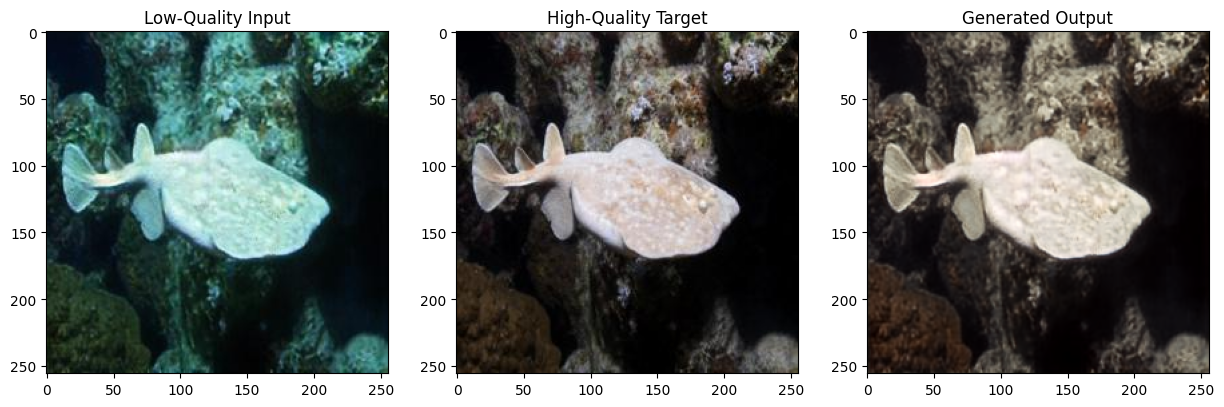


Starting Epoch 6/10...


Training Epoch: 100%|██████████| 1430/1430 [14:21<00:00,  1.66it/s, loss=0.0327]


Checkpoint saved to checkpoints\checkpoint_epoch6.pth

Starting Epoch 7/10...


Training Epoch: 100%|██████████| 1430/1430 [14:21<00:00,  1.66it/s, loss=0.0327]


Checkpoint saved to checkpoints\checkpoint_epoch7.pth

Starting Epoch 8/10...


Training Epoch: 100%|██████████| 1430/1430 [14:20<00:00,  1.66it/s, loss=0.0161]


Checkpoint saved to checkpoints\checkpoint_epoch8.pth

Starting Epoch 9/10...


Training Epoch: 100%|██████████| 1430/1430 [14:18<00:00,  1.67it/s, loss=0.0219]


Checkpoint saved to checkpoints\checkpoint_epoch9.pth

Starting Epoch 10/10...


Training Epoch: 100%|██████████| 1430/1430 [14:19<00:00,  1.66it/s, loss=0.0218]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061520755..1.0353074].


Checkpoint saved to checkpoints\checkpoint_epoch10.pth


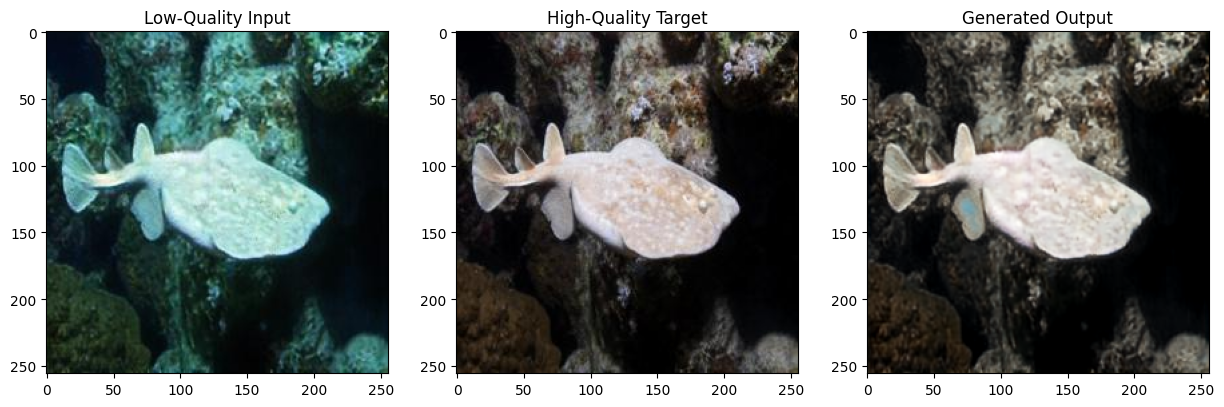

Training Complete.


In [12]:
for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")

    train_one_epoch(dataloader, model, optimizer, criterion, device)
    
    scheduler.step()

    save_checkpoint(model, optimizer, filename=f"checkpoint_epoch{epoch+1}.pth")

    if (epoch + 1) % 5 == 0:
        low_quality, high_quality = dataset[0]
        low_quality = low_quality.unsqueeze(0).to(device)
        high_quality = high_quality.unsqueeze(0).to(device)

        with torch.no_grad():
            generated = model(low_quality)

        visualize_samples(low_quality.squeeze(), high_quality.squeeze(), generated.squeeze())

print("Training Complete.")

C:\Users\niels\AppData\Local\Temp\ipykernel_4120\3154571830.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


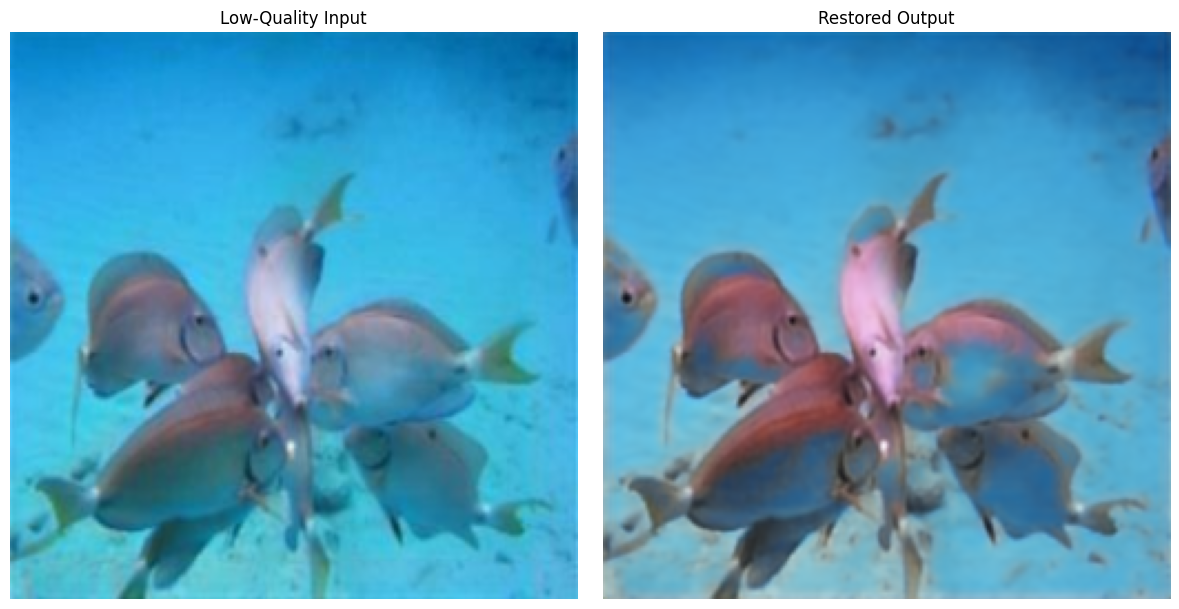

In [13]:
# Load model architecture
model = DeconvolutionModel()

# Load the checkpoint
checkpoint_path = "checkpoints/checkpoint_epoch10.pth"
checkpoint = torch.load(checkpoint_path)

# Load the model state_dict from the checkpoint
model.load_state_dict(checkpoint["model_state_dict"])

# Set the model to evaluation mode
model.eval()

def prepare_input_image(image_path, transform):
    img = Image.open(image_path).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    return img

def run_inference(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image = prepare_input_image(image_path, transform).to(device)

    with torch.no_grad():
        output = model(input_image)

    return output

def visualize_output(input_image, output_image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    if isinstance(input_image, Image.Image):
        input_image = transform(input_image).unsqueeze(0)
        
    def denormalize(img):
        img = img * 0.5 + 0.5
        img = img.permute(1, 2, 0).cpu().numpy()
        return img

    input_img = denormalize(input_image.squeeze(0))
    output_img = denormalize(output_image.squeeze(0))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(input_img)
    axes[0].set_title("Low-Quality Input")
    axes[0].axis('off')

    axes[1].imshow(output_img)
    axes[1].set_title("Restored Output")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

image_path = "../data/EUVP/Unpaired/trainA/nm_3194up.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

output_image = run_inference(model, image_path, device)

input_image = Image.open(image_path)

visualize_output(input_image, output_image)